In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)

from regain import utils; reload(utils);


# ISING

In [2]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
#import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=50,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [3]:
import pickle as pkl
with open("../../../../projects/time_exponential_family/data/data_ising_temporal_test_50nodes.pkl", "wb") as f:
    pkl.dump([samples, thetas], f)

In [5]:
# with open("../../../../projects/time_exponential_family/data/data_ising_temporal_test_50nodes.pkl", "rb") as f:
#     samples, thetas = pkl.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../../../../projects/time_exponential_family/data/data_ising_temporal_test_50nodes.pkl'

In [4]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import IsingGraphicalModel
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)

from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

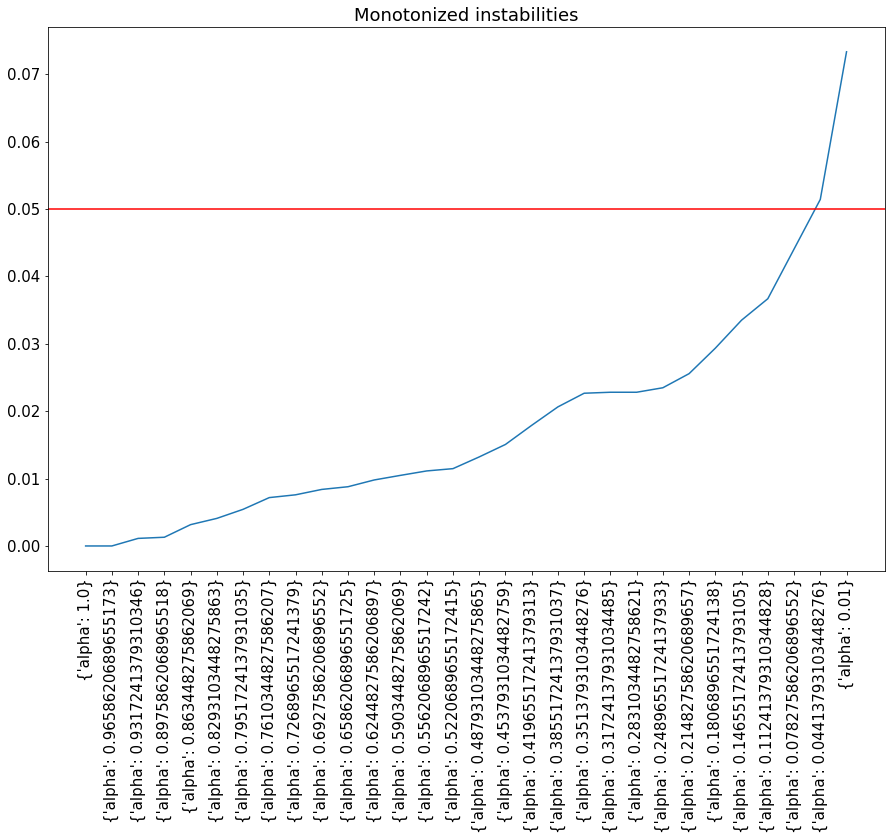

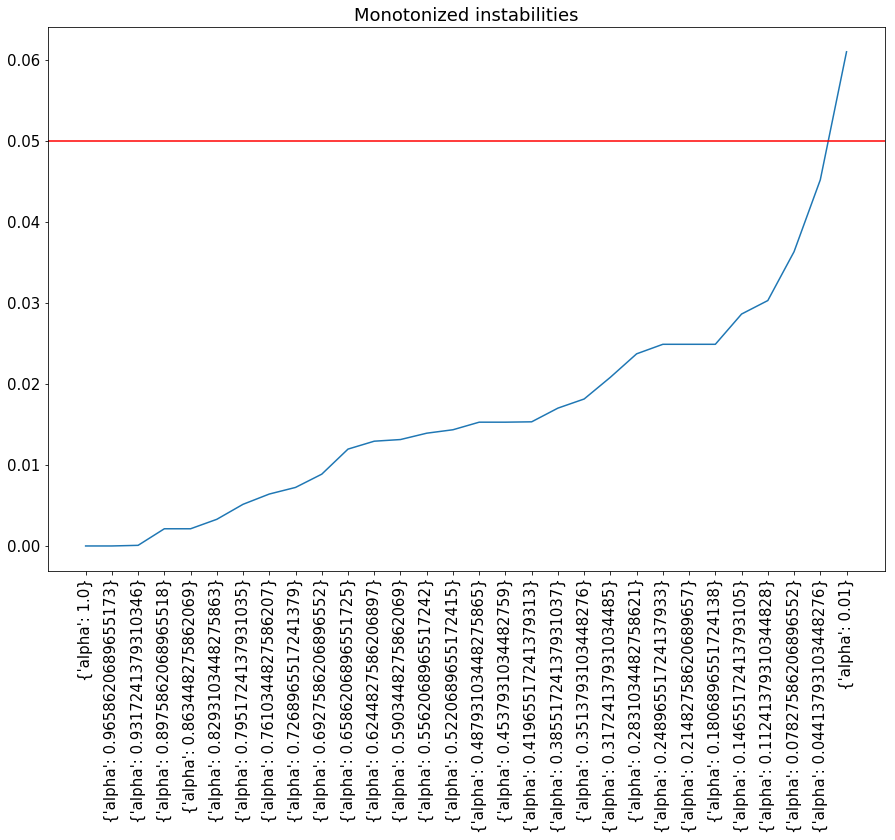

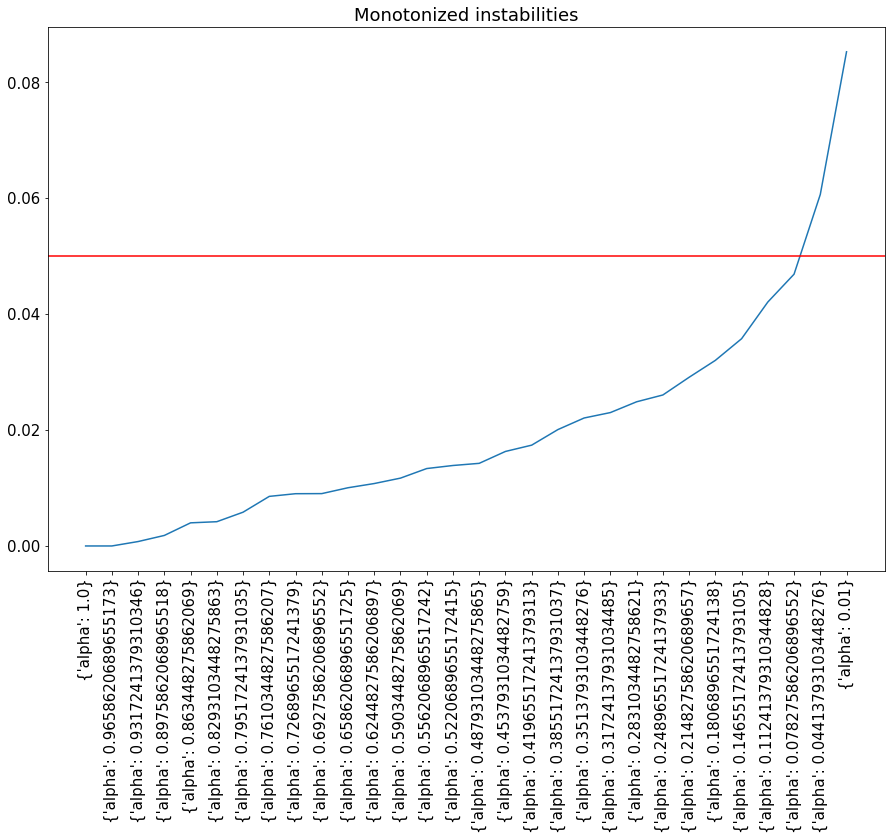

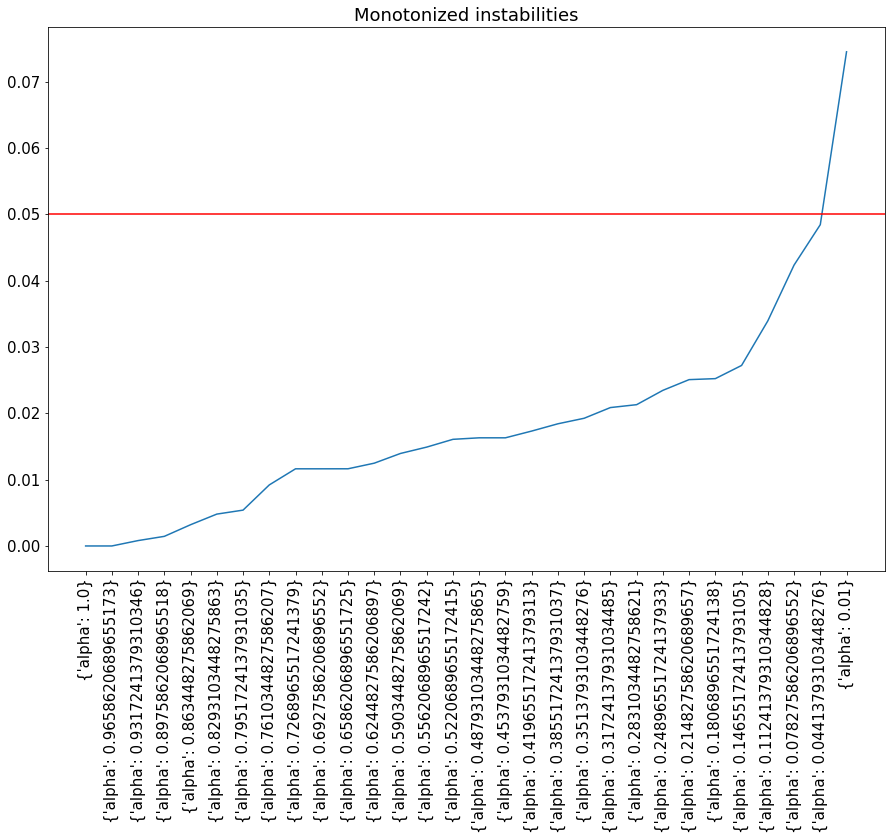

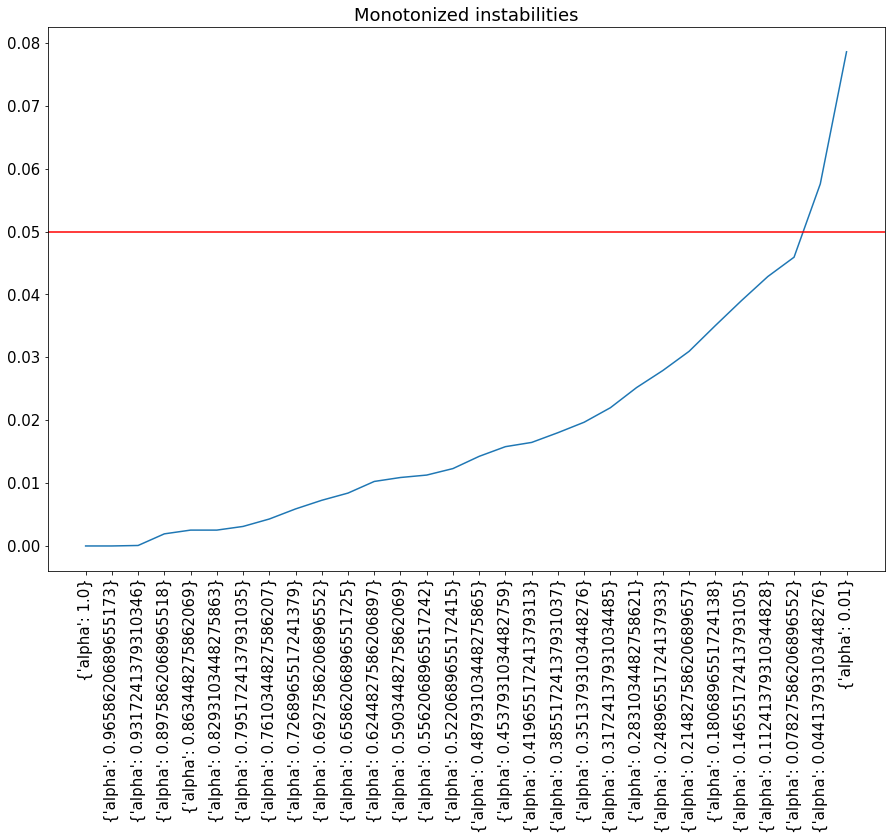

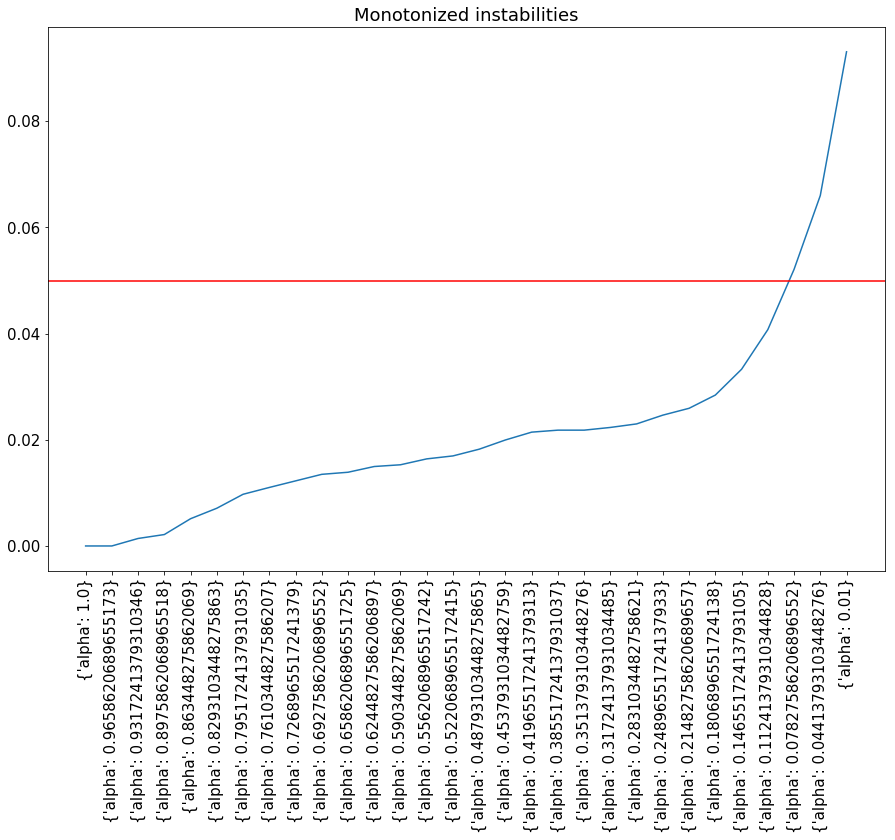

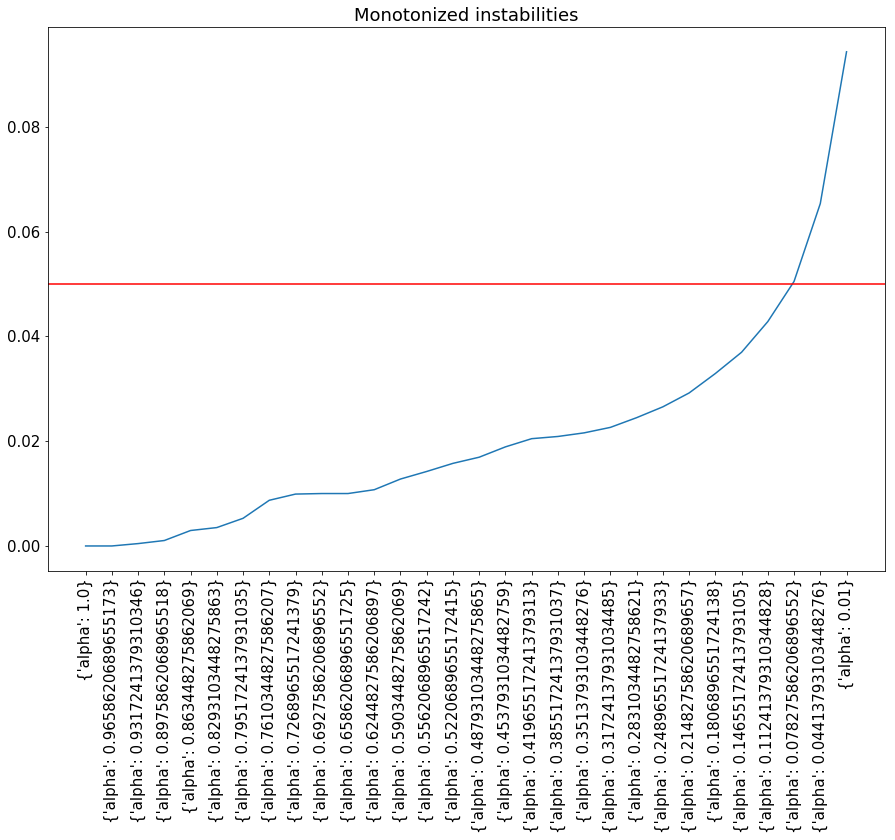

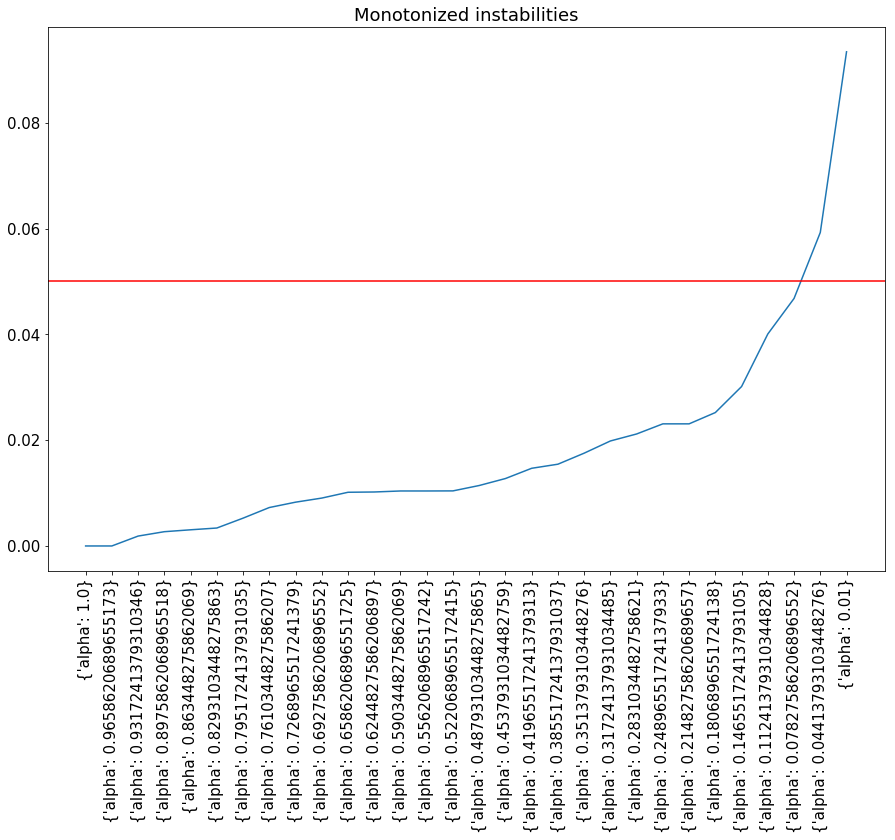

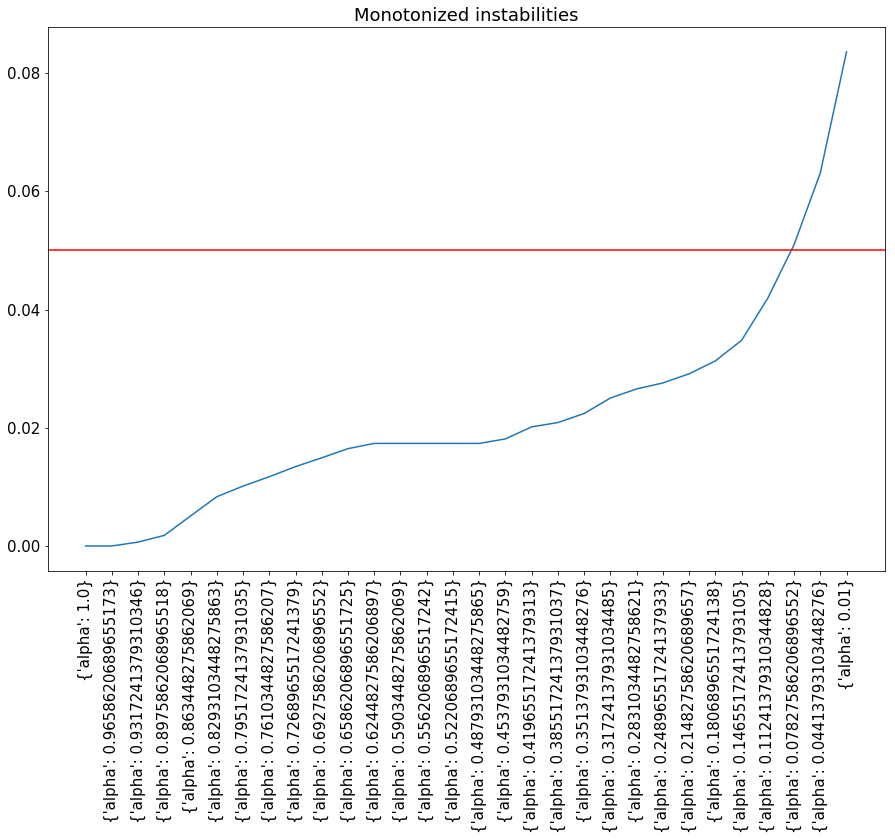

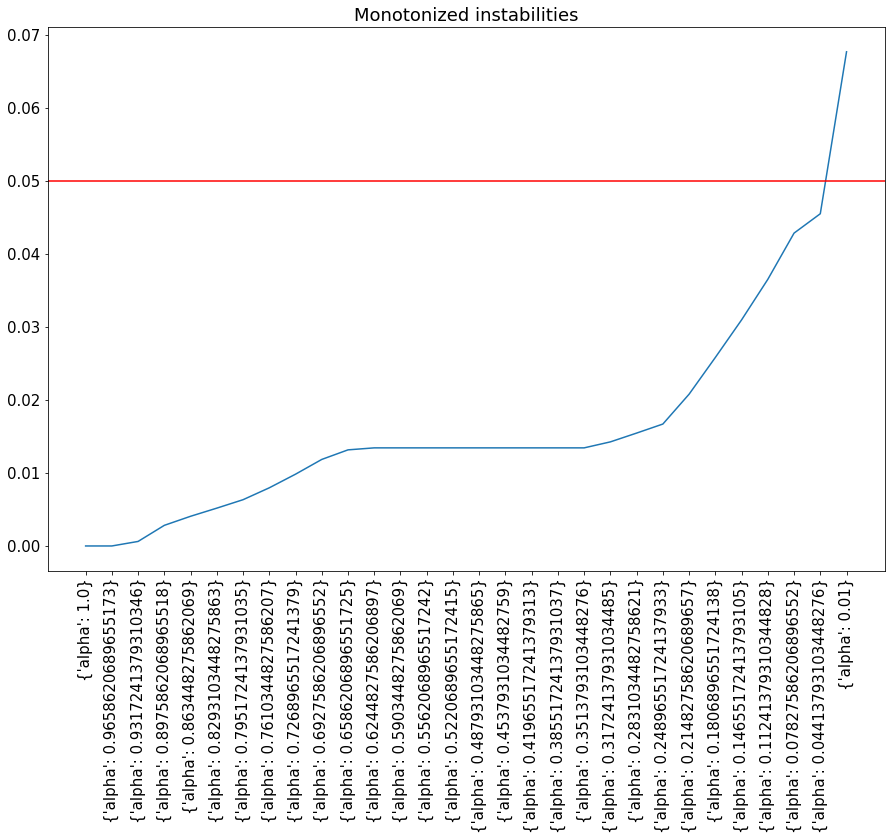

In [8]:
ising_mdl = IsingGraphicalModel(alpha=0.32, mode='symmetric_fbs', verbose=0)

params = []
estimators = []
for i in range(10):
    cv = GraphicalModelStabilitySelection(ising_mdl, param_grid={'alpha':np.linspace(0.01, 1, 30)},
                                          sampling_size=80,
                                         n_repetitions=20)
    cv.fit(samples[i])
    params.append(cv.best_params_['alpha'])
    estimators.append(cv.best_estimator_)
    cv.plot()

In [9]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=10)

precisions = []
for train, test in sss.split(samples[0]):
    precs= []
    for i, e in enumerate(estimators):
        e.fit(samples[i][train, :])
        precs.append(e.precision_)
    precisions.append(np.array(precs))

In [15]:
precisions[0].shape

(10, 50, 50)

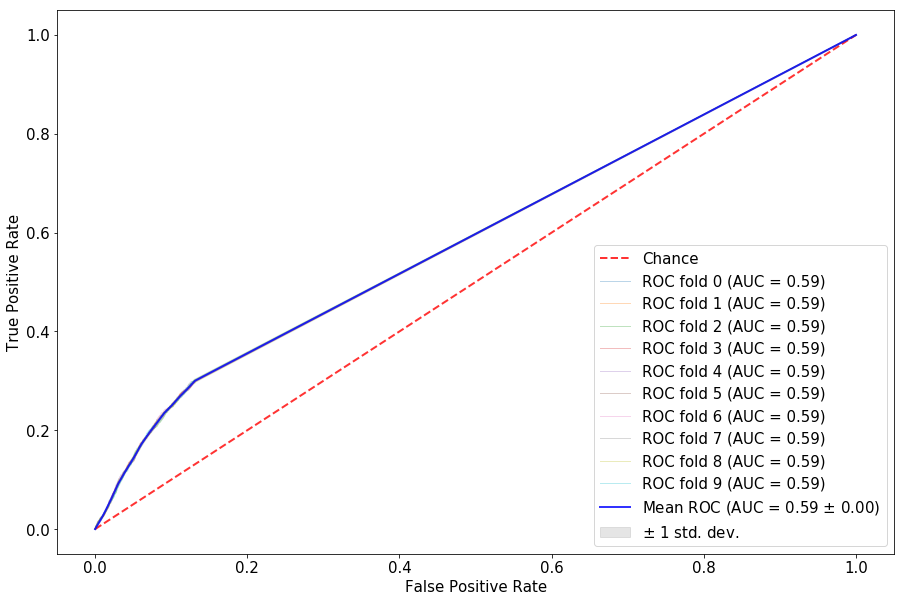

In [16]:
from regain.plotting.results import plot_roc_curves
plot_roc_curves(np.array(thetas), [np.abs(p) for p in precisions])

In [17]:
params

[0.07827586206896552,
 0.04413793103448276,
 0.07827586206896552,
 0.04413793103448276,
 0.07827586206896552,
 0.11241379310344828,
 0.11241379310344828,
 0.07827586206896552,
 0.11241379310344828,
 0.04413793103448276]

In [14]:
utils.structure_error(np.array(thetas), np.array(precisions), no_diagonal=True)

ValueError: The first argument must be one or two dimensional array. A 3-dimensional array is not permitted

In [ ]:
import pickle as pkl

In [ ]:
with open("../../../../projects/time_exponential_family/results_ising/results_single_10nodes.pkl", "wb") as f:
    pkl.dump([precisions, params], f)


In [ ]:
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection
cv = GraphicalModelStabilitySelection(mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                      sampling_size=800, plot=True, 
                                      n_repetitions=20)
cv.fit(X, y)

In [21]:
#import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_temporal_linear_model.ising import TemporalIsingModel

from sklearn.gaussian_process import kernels

kernel = kernels.RBF(length_scale=2)(np.arange(10)[:, None])
#kernel = np.ones((10,10))*1
#np.fill_diagonal(kernel, 1)
mdl = TemporalIsingModel(
        alpha=np.mean(params),  psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernel,  init='zeros', verbose=0)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [22]:
mdl.fit(X, y)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10)

precisions_time = []
for train, test in sss.split(X, y):
    mdl.fit(X[train, :], y[train])
    precisions_time.append(mdl.precision_)

In [ ]:
utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)

In [ ]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_roc_curves, plot_precision_recall_comparison, plot_roc_comparison

plot_roc_comparison(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]})

In [ ]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_roc_curves, plot_precision_recall_comparison, plot_roc_comparison

plot_precision_recall_comparison(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]})

In [ ]:
import regain.utils; reload(regain.utils)
from regain.utils import structure_error, mean_structure_error

In [ ]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions])

In [ ]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions_time])